# Predicting Walmart Store Sales 

**Author: Joel Ligma**            
<br>
**Date: July 2020 - July 2020**


**Context**

The data provided for this project contains historical sales data for 45 Walmart stores located in different regions of the US. Each store contains a number of departments, and the goal for this project is to predict the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. 

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

Dataset Link: https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview/description

## Table of Contents
**1) Data Preprocessing and Merging Multiple Datasets** 
- Data Cleaning
- Dealing with Missing Values
- Merging
<br>

**2) Exploratory Data Analysis (EDA)**
- Summary Statistics
- Univariate Analysis
- Bivariate Analysis
<br>

**3) Data Preparation**
- Dealing with Outliers
- Feature Correlation
- Dummy Coding
- Identifying and Removing NZV/ ZV Predictors
- Training, Validation and Test Split
- Scaling Data
<br>

**4) Model Building & Validation**
- Linear regression
- Random Forest
- XGBoost Regressor
- Model Comparison
<br>

**5) Saving the Model**
- Saving the Best Performing Model for Future Deployment
<br>

In [57]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os # change wd

# data prep
from sklearn.impute import SimpleImputer
import csv # write csv file of the complete dataset
from sklearn.preprocessing import MinMaxScaler # for scaling
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats


# model building
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# model validation
from sklearn import metrics 

# saving the best performing model
from sklearn.externals import joblib

In [35]:
pwd

'C:\\Users\\joell\\Downloads\\walmart-recruiting-store-sales-forecasting'

In [36]:
# change wd
os.chdir('C:\\Users\\joell\\Downloads\\walmart-recruiting-store-sales-forecasting')

In [19]:
# load data
stores = pd.read_csv("stores.csv")
features = pd.read_csv("features.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 1) Merging Multiple Datasets

# Stores Dateset


This file contains anonymized information about the 45 stores, indicating the type and size of store.


- Store - the store number
- Type - the store type
- Size - the store size in square feet


In [5]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [6]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


# **Features Dataset**


- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after - Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [8]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [9]:
print("The Walmart sales data was collected between {} and {}".format(features["Date"].min(), features["Date"].max()))

The Walmart sales data was collected between 2010-02-05 and 2013-07-26


In [10]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


### Dealing with Missing Values

**Markdown 1**

In [11]:
print("Total number of values in column: {}".format(features["MarkDown1"].notna().sum()))
print("Unique values: {}".format(features["MarkDown1"].nunique()))
print("Average value: {}".format(round(features["MarkDown1"].mean(),2)))
print("Median value:  {}".format(features["MarkDown1"].median()))

Total number of values in column: 4032
Unique values: 4023
Average value: 7032.37
Median value:  4743.58


Looks like almost all **markdown1** values are unique values. The average value is much higher than the median value which implies a positvely skewed distribution and the existence of some very high values in the dataset.

**Markdown 2**

In [12]:
print("Total number of values in column: {}".format(features["MarkDown2"].notna().sum()))
print("Unique values: {}".format(features["MarkDown2"].nunique()))
print("Average value: {}".format(round(features["MarkDown2"].mean(),2)))
print("Median value:  {}".format(features["MarkDown2"].median()))

Total number of values in column: 2921
Unique values: 2715
Average value: 3384.18
Median value:  364.57


**Markdown 3**

In [13]:
print("Total number of values in column: {}".format(features["MarkDown3"].notna().sum()))
print("Unique values: {}".format(features["MarkDown3"].nunique()))
print("Average value: {}".format(round(features["MarkDown3"].mean(),2)))
print("Median value:  {}".format(features["MarkDown3"].median()))

Total number of values in column: 3613
Unique values: 2885
Average value: 1760.1
Median value:  36.26


**Markdown 4**

In [14]:
print("Total number of values in column: {}".format(features["MarkDown4"].notna().sum()))
print("Unique values: {}".format(features["MarkDown4"].nunique()))
print("Average value: {}".format(round(features["MarkDown4"].mean(),2)))
print("Median value:  {}".format(features["MarkDown4"].median()))

Total number of values in column: 3464
Unique values: 3405
Average value: 3292.94
Median value:  1176.425


**Markdown 5**

In [15]:
print("Total number of values in column: {}".format(features["MarkDown5"].notna().sum()))
print("Unique values: {}".format(features["MarkDown5"].nunique()))
print("Average value: {}".format(round(features["MarkDown5"].mean(),2)))
print("Median value:  {}".format(features["MarkDown5"].median()))

Total number of values in column: 4050
Unique values: 4045
Average value: 4132.22
Median value:  2727.135


We can observe similar findings in all other markdown features.

Next, let's take a look at **CPI** and **Unemployment** which also showed missing values.

**CPI - Consumer Price Index**

In [16]:
print("Total number of values in column: {}".format(features["CPI"].notna().sum()))
print("Unique values: {}".format(features["CPI"].nunique()))
print("Average value: {}".format(round(features["CPI"].mean(),2)))
print("Median value:  {}".format(features["CPI"].median()))

Total number of values in column: 7605
Unique values: 2505
Average value: 172.46
Median value:  182.7640032


For the **Consumer Price Index** feature, the mean is actually lower than the median, implying that the distribution is negatively skewed. Let's also use the median for this feature.

**Unemployment**

In [17]:
print("Total number of values in column: {}".format(features["Unemployment"].notna().sum()))
print("Unique values: {}".format(features["Unemployment"].nunique()))
print("Average value: {}".format(round(features["Unemployment"].mean(),2)))
print("Median value:  {}".format(features["Unemployment"].median()))

Total number of values in column: 7605
Unique values: 404
Average value: 7.83
Median value:  7.806


For the **unemployment** feature, mean and median are almost identical, implying a normal distribution. For simplicity, let's also take the median for missing value imputation.

### Value Imputation

**Imputing Median for missing values for CPI and Unemployment**

In [40]:
# separate features into new dataframe for imputation
features_imp = features[{"CPI", "Unemployment"}]
# create imputer instance
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# fit imputer on data
imp_median.fit(features_imp)
# transform data
features_imp = imp_median.transform(features_imp)
# convert np array to dataframe
features_imp = pd.DataFrame(features_imp)
# rename columns 
features_imp.rename(columns={0: "CPidx", 1: "Unemp_rate"}, inplace=True)
# concat the two dataframes 
features = pd.concat([features, features_imp], axis=1, ignore_index=False)
# drop the old markdown columns
features.drop(columns=["CPI", "Unemployment"], inplace=True)
# let's check the results
features.info()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,CPidx,Unemp_rate
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,False,211.096358,8.106
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,True,211.242170,8.106
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,False,211.289143,8.106
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,False,211.319643,8.106
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,False,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,False,182.764003,7.806
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,False,182.764003,7.806
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,False,182.764003,7.806
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,False,182.764003,7.806


**Imputing Median for missing values for the 5 Markdown features**

In [46]:
# fill NaNs with 0 because the promotional markdown events happen throughout the year and precede prominent holiday
# This means that they are not happening thoughout the year and hence will be set to 0 instead of getting dropped or imputed by 
# the mean or median etc.
features["MarkDown1"].fillna(value=0,inplace=True)
features["MarkDown2"].fillna(value=0,inplace=True)
features["MarkDown3"].fillna(value=0,inplace=True)
features["MarkDown4"].fillna(value=0,inplace=True)
features["MarkDown5"].fillna(value=0,inplace=True)

Next, let's convert the feature **IsHoliday** to dummy.

In [47]:
features["IsHoliday"] = features["IsHoliday"].astype(int)

# Merging the 2 datasets

In [48]:
merge_1 = pd.merge(stores, features, on="Store", how="outer") 

In [49]:
# just a quick look if Store == Type or not - it's not
merge_1.sort_values("Type")

,Store,Type,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,CPidx,Unemp_rate
0,1,A,151315,2010-02-05,42.31,2.572,0.00,0.00,0.00,0.0,0.00,0,211.096358,8.106
5831,33,A,39690,2010-03-26,64.09,2.980,0.00,0.00,0.00,0.0,0.00,0,126.605064,10.115
5830,33,A,39690,2010-03-19,64.60,3.054,0.00,0.00,0.00,0.0,0.00,0,126.606645,10.115
5829,33,A,39690,2010-03-12,55.61,3.034,0.00,0.00,0.00,0.0,0.00,0,126.604286,10.115
5828,33,A,39690,2010-03-05,59.17,2.877,0.00,0.00,0.00,0.0,0.00,0,126.578286,10.115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6826,38,C,39690,2011-11-11,48.76,3.824,149.19,691.41,6.05,0.0,1571.53,0,129.816710,12.890
6827,38,C,39690,2011-11-18,54.20,3.813,27.61,8.22,1.32,0.0,2034.39,0,129.826833,12.890
6828,38,C,39690,2011-11-25,53.25,3.622,17.17,0.00,5.26,0.0,615.68,1,129.836400,12.890
7463,42,C,39690,2010-02-12,49.96,2.828,0.00,0.00,0.00,0.0,0.00,1,126.496258,9.765


# Merging this new dataset with Train Dataset

**Train Dataset**

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


We will join these on **Store** and **Date** to ensure the correct values for each store at each specific date.

In [50]:
df = pd.merge(train, merge_1, on=["Store", "Date"], how="inner")

In [51]:
# check if IsHoliday_x values are all in IsHoliday_y
df["IsHoliday_x"].isin(df["IsHoliday_y"]).all()

True

In [52]:
# let's drop IsHoliday_x and rename the remaining column
df.drop(columns="IsHoliday_x", inplace=True)
df.rename(columns={"IsHoliday_y" : "IsHoliday"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   Type          421570 non-null  object 
 5   Size          421570 non-null  int64  
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     421570 non-null  float64
 9   MarkDown2     421570 non-null  float64
 10  MarkDown3     421570 non-null  float64
 11  MarkDown4     421570 non-null  float64
 12  MarkDown5     421570 non-null  float64
 13  IsHoliday     421570 non-null  int32  
 14  CPidx         421570 non-null  float64
 15  Unemp_rate    421570 non-null  float64
dtypes: float64(10), int32(1), int64(3), object(2)
memory usage: 53.1+ MB


In [53]:
# Write csv file of the step2 data set 
df.to_csv("walmart.csv")

# 2) Exploratory Data Analysis (EDA)

In [37]:
# load dataset
df = pd.read_csv("walmart.csv")
# this column was added automatically presumably as index, let's drop it
df.drop(columns="Unnamed: 0", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   Type          421570 non-null  object 
 5   Size          421570 non-null  int64  
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     421570 non-null  float64
 9   MarkDown2     421570 non-null  float64
 10  MarkDown3     421570 non-null  float64
 11  MarkDown4     421570 non-null  float64
 12  MarkDown5     421570 non-null  float64
 13  IsHoliday     421570 non-null  int64  
 14  CPidx         421570 non-null  float64
 15  Unemp_rate    421570 non-null  float64
dtypes: float64(10), int64(4), object(2)
memory usage: 51.5+ MB


## 1. Summary Statistics

In [55]:
df.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,CPidx,Unemp_rate
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,0.070358,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,0.255750,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,0.000000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,0.000000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,1.000000,227.232807,14.313000


## 2. Univariate Analysis

**Weekly Sales** has been identified as the response variable for this project.

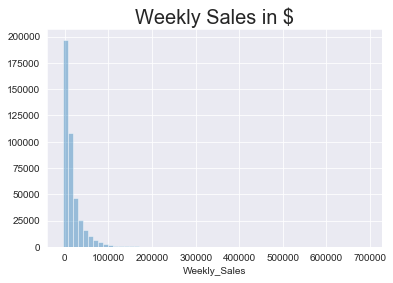

In [56]:
sns.set_style('darkgrid') # set style
plt.title("Weekly Sales in $", size=20)
sns.distplot(df["Weekly_Sales"], kde=False, bins=60)

In [57]:
print("Median: {}".format(df["Weekly_Sales"].median()))
print("Mean: {}".format(round(df["Weekly_Sales"].mean())))
print("Max: {}".format(round(df["Weekly_Sales"].max())))

Median: 7612.03
Mean: 15981
Max: 693099


It seems we have a few outliers in the dataset which generated very high sales. Let's take a closer look at the data by omitting any values above 100,000 USD.

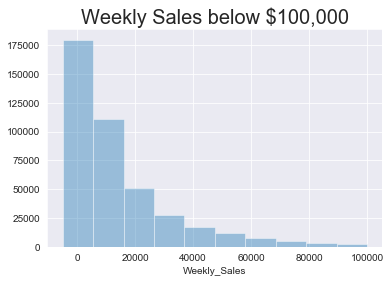

In [58]:
x = df["Weekly_Sales"][df.Weekly_Sales < 100000]
sns.set_style('darkgrid') # set style
plt.title("Weekly Sales below $100,000", size=20)
sns.distplot(x, kde=False, bins=10)

It looks like the majority of weekly sales values lie roughly between 0 and 30,000 USD. Let's take a brief look at the weekly sales losses.

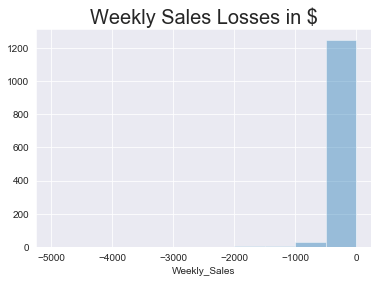

In [59]:
y = df["Weekly_Sales"][df.Weekly_Sales < 0]
sns.set_style('darkgrid') # set style
plt.title("Weekly Sales Losses in $", size=20)
sns.distplot(y, kde=False, bins=10)

In [60]:
print("The majorty of losses are between 0 and -1,000 USD with the largest loss of {} USD".format(y.min()))

The majorty of losses are between 0 and -1,000 USD with the largest loss of -4988.94 USD


Therefore, overall, Walmart appears to be quite profitable in the period documented in our dataset.

## 3. Bivariate Analysis

**Weekly Sales by Date**

In [4]:
# convert Date from object to datetime
df["Date"] = pd.to_datetime(df["Date"])

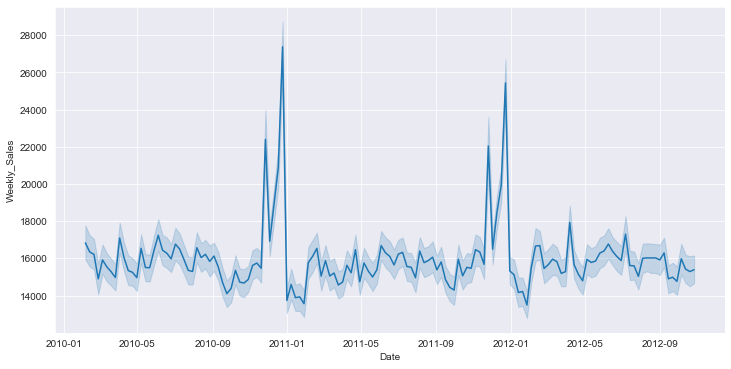

In [32]:
sns.set_style('darkgrid') # set style
plt.figure(figsize=(12,6))
sns.lineplot(x="Date",y="Weekly_Sales", data=df)

**Weekly Sales by Year**

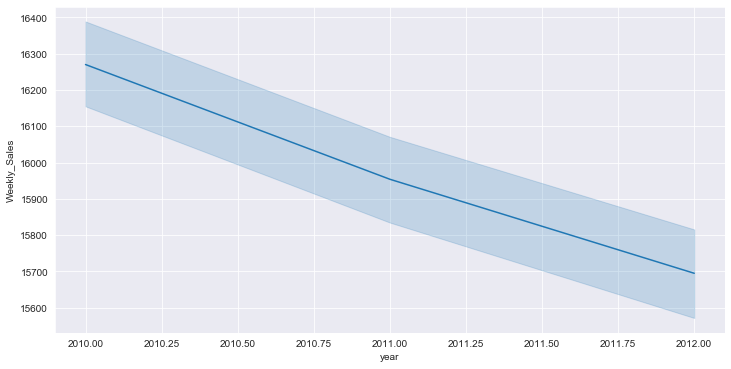

In [37]:
# extract year from the Date feature
df["year"] = df["Date"].dt.year

# plot lineplot by year
sns.set_style('darkgrid') # set style
plt.figure(figsize=(12,6))
sns.lineplot(x="year",y="Weekly_Sales", data=df)

**Weekly Sales by Month**

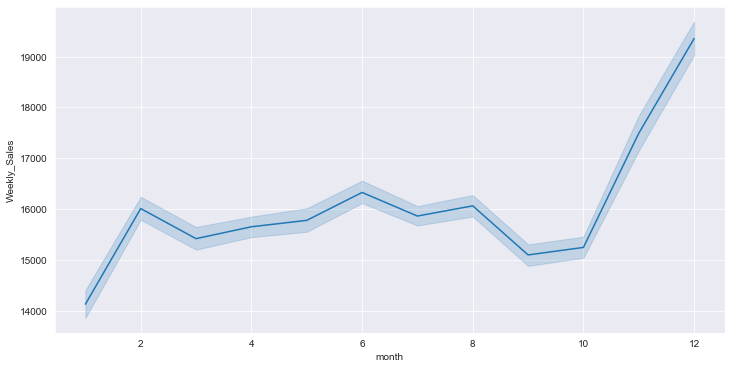

In [38]:
# extract month from the Date feature
df["month"] = df["Date"].dt.month

# plot lineplot by month
sns.set_style('darkgrid') # set style
plt.figure(figsize=(12,6))
sns.lineplot(x="month",y="Weekly_Sales", data=df)

In the visualizations depicted above, we can observe that overall **weekly sales** decreased slightly over time. Towards the end of the year, sales increase significantly while in January weekly sales are the lowest. Presumably, the increase in sales is linked to the holiday period during the end of each year.

When looking at the first plot, we can observe multiple dates with very large **weekly sales** values. Let's see if we can figure out the exact dates and verify our hypothesis. For convenience, the holiday dates are listed below.

**Holidays** 

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

As we can see the highest weekly sales were generated on Thanksgiving holiday 2010.

In [69]:
df['Weekly_Sales'].nlargest(5)

90645     693099.36
337053    649770.18
94393     630999.19
333594    627962.93
131088    474330.10
Name: Weekly_Sales, dtype: float64

In [38]:
print("Highest Weekly Sales Date: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"].max(), 'Date']))
print("2nd Highest Weekly Sales Date: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][337053], 'Date']))
print("3rd Highest Weekly Sales Date: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][94393], 'Date']))
print("4th Highest Weekly Sales Date: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][333594], 'Date']))
print("5th Highest Weekly Sales Date: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][131088], 'Date']))
print("6th Weekly Sales Date: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"].max(), 'Date']))
print("7th Highest Weekly Sales Date: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][337053], 'Date']))
print("8th Highest Weekly Sales Date: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][94393], 'Date']))
print("9th Highest Weekly Sales Date: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][333594], 'Date']))
print("10th Highest Weekly Sales Date: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][131088], 'Date']))

Highest Weekly Sales Date: 90645    2010-11-26
Name: Date, dtype: object
2nd Highest Weekly Sales Date: 337053    2011-11-25
Name: Date, dtype: object
3rd Highest Weekly Sales Date: 94393    2011-11-25
Name: Date, dtype: object
4th Highest Weekly Sales Date: 333594    2010-11-26
Name: Date, dtype: object
5th Highest Weekly Sales Date: 131088    2010-11-26
Name: Date, dtype: object
6th Weekly Sales Date: 90645    2010-11-26
Name: Date, dtype: object
7th Highest Weekly Sales Date: 337053    2011-11-25
Name: Date, dtype: object
8th Highest Weekly Sales Date: 94393    2011-11-25
Name: Date, dtype: object
9th Highest Weekly Sales Date: 333594    2010-11-26
Name: Date, dtype: object
10th Highest Weekly Sales Date: 131088    2010-11-26
Name: Date, dtype: object


From the analysis above, we can infer that the highest weekly sales were all generated during Thanksgiving holiday.This seems to be the most profitable holiday for Walmart.  

**Weekly Sales and Holidays**

(-5000, 60000)

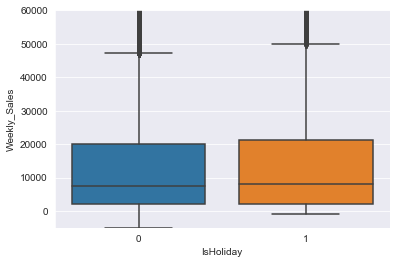

In [47]:
sns.set_style('darkgrid') # set style
g=sns.boxplot(x="IsHoliday", y="Weekly_Sales", data=df)
g.set_ylim(bottom=-5000, top=60000)

In the boxplot depicted above, we can observe that during holidays, weekly sales are slightly higher than during regular days.

**Weekly Sales and Temperature**

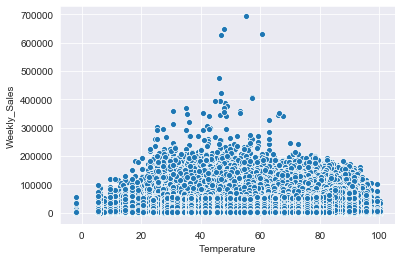

In [46]:
sns.set_style('darkgrid') # set style
sns.scatterplot(x="Temperature", y="Weekly_Sales", data=df)

It appears that the temperature has an impact on Weekly Sales. Weekly Sales are higher on days where the temperature is between 25 and 75 degrees fahrenheit. If the temperature is too warm or too cold consumers might not want to go out to shop due to the unpleasant temperatures.

**Weekly Sales and Store Type**

(-5000, 100000)

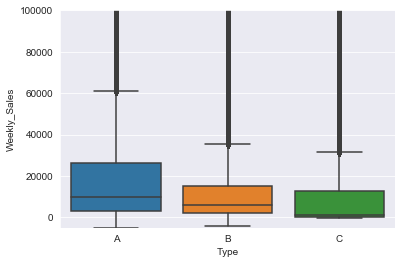

In [93]:
sns.set_style('darkgrid') # set style
g=sns.boxplot(x="Type", y="Weekly_Sales", data=df)
g.set_ylim(bottom=-5000, top=100000)

We can observe similar findings as for Weekly Sales and Holidays. Let's see how it looks after removing these unusally high sales.

We can see that store **type A** generated the highest weekly sales followed by store **type B**. Store **type C** generated the lowest sales. 

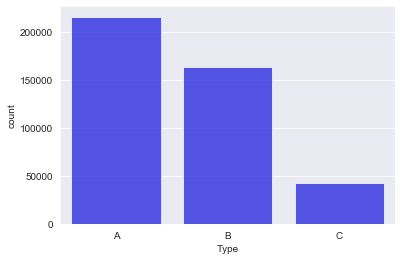

In [85]:
sns.countplot(x="Type", data=df, color="blue", alpha=0.75)

However, as we can see, Store Type A has the most stores in the country, followed by store type B. This could explain why these store types generate more sales.

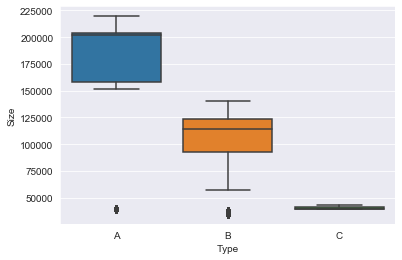

In [86]:
sns.boxplot(x="Type", y="Size",data=df)

Now we can see that there are not only more stores of types A and B but they are also much larger in terms of size. Hence we can infer that larger stores also generate larger weekly sales.

**Weekly Sales and Department Store Number**

Text(0.5, 1.0, 'Weekly Sales per Department')

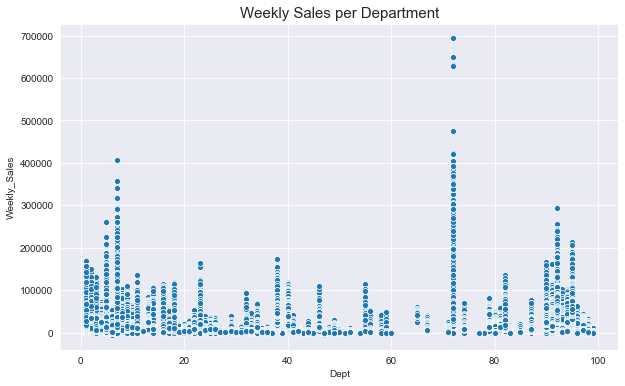

In [52]:
plt.figure(figsize=(10,6))
g=sns.scatterplot(x="Dept", y="Weekly_Sales", data=df)
g.set_title("Weekly Sales per Department", size=15)

In [34]:
# Let's examine the top 10 departments with the highest weekly sales
print("Department with Highest Weekly Sales: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][90645], 'Dept']))
print("Department with 2nd Highest Weekly Sales: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][337053], 'Dept']))
print("Department with 3rd Highest Weekly Sales: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][94393], 'Dept']))
print("Department with 4th Highest Weekly Sales: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][333594], 'Dept']))
print("Department with 5th Highest Weekly Sales: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][131088], 'Dept']))
print("Department with 6th Highest Weekly Sales: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][190370], 'Dept']))
print("Department with 7th Highest Weekly Sales: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][259799], 'Dept']))
print("Department with 8th Highest Weekly Sales: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][90886], 'Dept']))
print("Department with 9th Highest Weekly Sales: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][90936], 'Dept']))
print("Department with 10th Highest Weekly Sales: {}".format(df.loc[df['Weekly_Sales'] == df["Weekly_Sales"][210037], 'Dept']))

Department with Highest Weekly Sales: 90645    72
Name: Dept, dtype: int64
Department with 2nd Highest Weekly Sales: 337053    72
Name: Dept, dtype: int64
Department with 3rd Highest Weekly Sales: 94393    72
Name: Dept, dtype: int64
Department with 4th Highest Weekly Sales: 333594    72
Name: Dept, dtype: int64
Department with 5th Highest Weekly Sales: 131088    72
Name: Dept, dtype: int64
Department with 6th Highest Weekly Sales: 190370    72
Name: Dept, dtype: int64
Department with 7th Highest Weekly Sales: 259799    72
Name: Dept, dtype: int64
Department with 8th Highest Weekly Sales: 90886    7
Name: Dept, dtype: int64
Department with 9th Highest Weekly Sales: 90936    72
Name: Dept, dtype: int64
Department with 10th Highest Weekly Sales: 210037    72
Name: Dept, dtype: int64


This is a very interesting finding. Based on the analysis above, we can observe that department 72 generated the 9 of the top 10 highest weekly sales and is therefore the top performing department. Department 7 generated the 8th highest weekly sales on one day. 

**Weekly Sales and Unemployment**

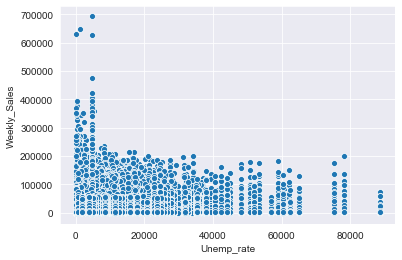

In [55]:
sns.scatterplot(x="Unemp_rate",y="Weekly_Sales", data=df)

As anticipated, weekly sales are high when unemployment is low due to consumers having more spending power. Inversely, when the unemployment rate increases, weekly sales decline due to consumers not having money to spend.

**Weekly Sales and Fuel Price**

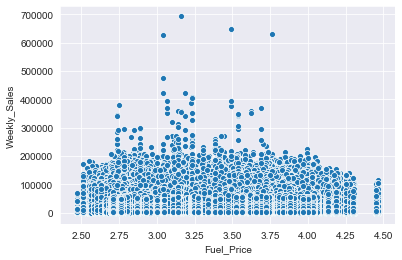

In [57]:
sns.scatterplot(x="Fuel_Price", y="Weekly_Sales", data=df)

Fuel prices can affect the economy. In the past it was observed that a side effect of fuel gas prices is "that discretionary spending of consumers goes down as they spend relatively more of their income on gasoline. Higher prices also mean that shoppers will tend to drive less - including to places like to mall or shopping center.". We can observe this behavior also in our data. For instance starting at a fuel price of around 3.8USD weekly sales are falling below 250,000USD.

Source: https://www.investopedia.com/financial-edge/0511/how-gas-prices-affect-the-economy.aspx#:~:text=%C2%A9TheBalance%202018-,Retailers,to%20mall%20or%20shopping%20center.

# 3) Data Preparation

**Examine if the feature IsHoliday covers all holidays documented in the dataset**

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [49]:
df.loc[df['IsHoliday'] == 1, 'Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [51]:
df.loc[df['IsHoliday'] == 0, 'Date'].unique()

array(['2010-02-05', '2010-02-19', '2010-02-26', '2010-03-05',
       '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02',
       '2010-04-09', '2010-04-16', '2010-04-23', '2010-04-30',
       '2010-05-07', '2010-05-14', '2010-05-21', '2010-05-28',
       '2010-06-04', '2010-06-11', '2010-06-18', '2010-06-25',
       '2010-07-02', '2010-07-09', '2010-07-16', '2010-07-23',
       '2010-07-30', '2010-08-06', '2010-08-13', '2010-08-20',
       '2010-08-27', '2010-09-03', '2010-09-17', '2010-09-24',
       '2010-10-01', '2010-10-08', '2010-10-15', '2010-10-22',
       '2010-10-29', '2010-11-05', '2010-11-12', '2010-11-19',
       '2010-12-03', '2010-12-10', '2010-12-17', '2010-12-24',
       '2011-01-07', '2011-01-14', '2011-01-21', '2011-01-28',
       '2011-02-04', '2011-02-18', '2011-02-25', '2011-03-04',
       '2011-03-11', '2011-03-18', '2011-03-25', '2011-04-01',
       '2011-04-08', '2011-04-15', '2011-04-22', '2011-04-29',
       '2011-05-06', '2011-05-13', '2011-05-20', '2011-

It does cover all holidays.

**Dealing with Outliers**

In [38]:
# extract the numeric features
df_numerics = df[["Weekly_Sales",'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
       'CPidx', 'Unemp_rate']]

# preserve column names
df_cols = df_numerics.columns;
df_numerics.columns = df_cols

In [39]:
# remove values which are not within 2.5 standard deviations of the mean
df_numerics = df_numerics[(np.abs(stats.zscore(df_numerics)) < 2.5).all(axis = 1)]
df_numerics

,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPidx,Unemp_rate
0,24924.50,151315,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106
1,50605.27,151315,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106
2,13740.12,151315,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106
3,39954.04,151315,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106
4,32229.38,151315,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106
...,...,...,...,...,...,...,...,...,...,...,...
421565,2487.80,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421566,5203.31,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421567,56017.47,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421568,6817.48,118221,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667


In [40]:
df.drop(columns={"Weekly_Sales",'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
       'CPidx', 'Unemp_rate'}, inplace=True)

In [41]:
# concatenate df with the df_numeric dataframe without outliers 
df = pd.concat([df_numerics, df], axis=1)

# drop missing values
df.dropna(inplace=True)

# reset index
df = df.reset_index(drop=True)

**Deriving a useful feature out of the DateTime feature "Date" for machine learning**

In [42]:
# convert Date from object to datetime
df["Date"] = pd.to_datetime(df["Date"])

# extract feature month from Date
df["week"] = df["Date"].dt.week

# drop the Date column since it is now redundant
df.drop(columns=["Date"], inplace=True)

**Dummy Coding**
- Type
- Dept 
- Store

In [43]:
# dummy coding the Type feature
df_dummies = pd.get_dummies(df['Type'])

# combine the df_dummies with the transcript dataframe
df = pd.concat([df, df_dummies], axis=1)
df.drop(columns="Type", inplace=True)

In [44]:
# dummy coding the Dept feature
df_dummies = pd.get_dummies(df['Dept'])

# combine the df_dummies with the transcript dataframe
df = pd.concat([df, df_dummies], axis=1)
df.drop(columns="Dept", inplace=True)

In [45]:
# dummy coding the Store feature
df_dummies = pd.get_dummies(df['Store'])

# combine the df_dummies with the transcript dataframe
df = pd.concat([df, df_dummies], axis=1)
df.drop(columns="Store", inplace=True)

**Feature Correlation**

In [46]:
df_matrix = df[["Weekly_Sales","Temperature", "Fuel_Price", "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5", 
               "CPidx", "Unemp_rate", "IsHoliday", "A", "B", "C", "Size", "week"]]

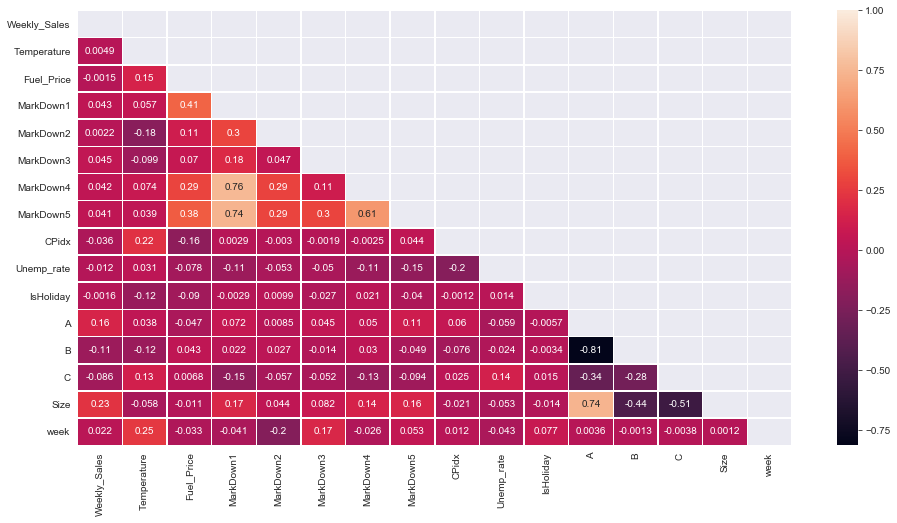

In [15]:
sns.set_style('darkgrid') # set style
plt.figure(figsize=(16,8))
# Compute the correlation matrix
corr = df_matrix.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# plot heatmap
sns.heatmap(df_matrix.corr(),yticklabels=True, annot=True,mask=mask,linewidths=.5)

**Dropping Features with a correlation of 0.7 or higher**

Let's keep all features for now.

In [47]:
df.drop(columns={"MarkDown1"}, inplace=True) 

**Dropping Features with near zero variance or zero variance**

In [48]:
df.shape

(361174, 141)

In [49]:
# dropping near zero variance features with .8 treshold
from sklearn.feature_selection import VarianceThreshold
treshold = VarianceThreshold(threshold=(.8 * (1 - .8)))
treshold.fit_transform(df)
features = df.columns.values[treshold.get_support(indices = True)]
feats = [column for column in df[features]] 
df.shape

(361174, 141)

There were no features with near zero variance or zero variance.

**Feature Correlation to the DV: Weeky Sales**

In [50]:
df.corr()["Weekly_Sales"].sort_values()

B              -0.106594
28             -0.098951
59             -0.098326
60             -0.097785
54             -0.090704
                  ...   
40              0.200565
95              0.200867
Size            0.226396
38              0.242076
Weekly_Sales    1.000000
Name: Weekly_Sales, Length: 141, dtype: float64

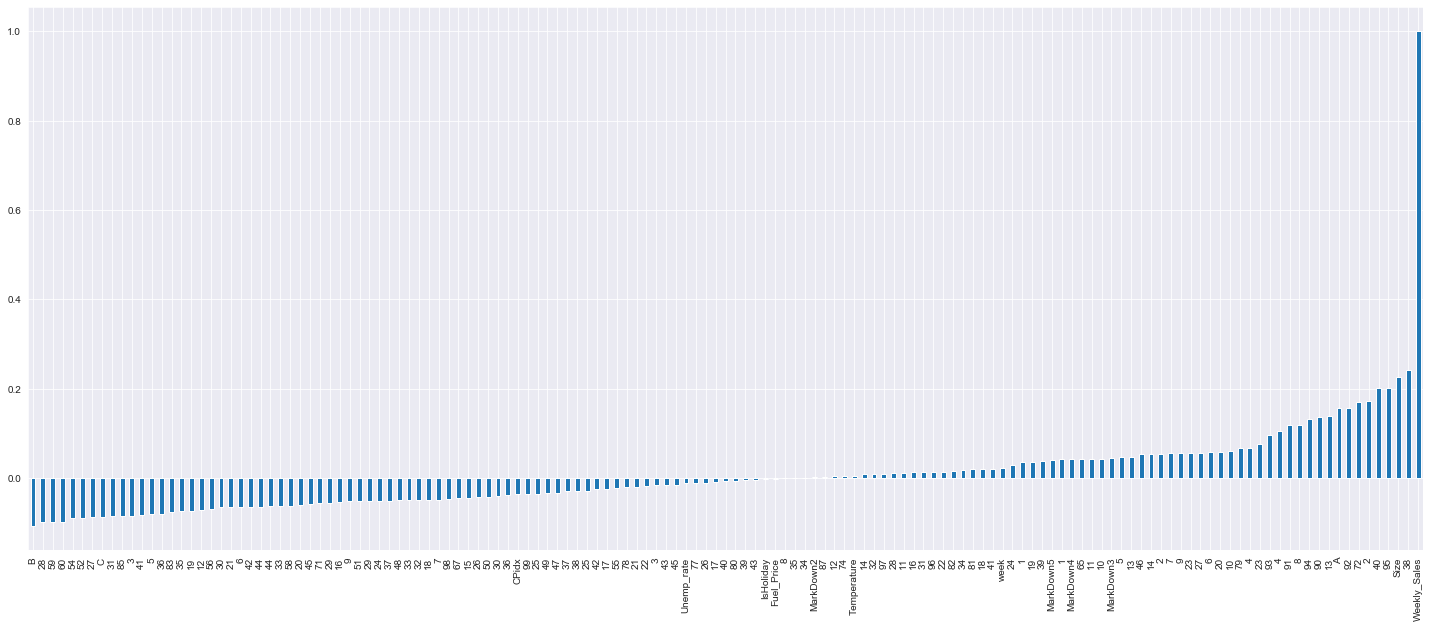

In [51]:
sns.set_style('darkgrid')
plt.figure(figsize=(25,10))
df.corr()["Weekly_Sales"].sort_values().plot(kind="bar")

**Data Partition into Training, Validation and Test Split**

In [52]:
# Split the data into training, validation and test datasets 
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=1)
df_valid, df_test = train_test_split(df_valid, test_size=0.2, random_state=1)

# separate the DV from the train/validation/test sets
X_train = df_train.drop(['Weekly_Sales'], axis=1)
y_train = df_train.Weekly_Sales.values
X_valid = df_valid.drop(['Weekly_Sales'], axis=1)
y_valid = df_valid.Weekly_Sales.values
X_test = df_test.drop(['Weekly_Sales'], axis=1)
y_test = df_test.Weekly_Sales.values

print("Training Data:", X_train.shape, y_train.shape,"\nValidation Data:", X_valid.shape, y_valid.shape,
      "\nTest Data:", X_test.shape, y_test.shape)

Training Data: (288939, 140) (288939,) 
Validation Data: (57788, 140) (57788,) 
Test Data: (14447, 140) (14447,)


**Feature Scaling using Normalization**

Explanation:

- MinMaxScaler(feature_range = (0, 1)) will transform each value in the column proportionally within the range [0,1]. It is a great choice to scale features to the same scale because it preserves the shape of the dataset, meaning there will be no distortion.

Equation:

- X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
- X_scaled = X_std * (max - min) + min
- where min, max = feature_range

In [53]:
# Since we have many different types of features in our dataset we should normalize the data to have all features
# on the same scale

# create an instance of MinMaxScaler
scaler = MinMaxScaler().fit(X_train)

# now perform the transformations on the training, validation and test set
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# 4) Model Building and Validation

**Steps for each model**
- **Create model instance**
- **Fit model on training data**
- **Calculate MAE, MSE, RMSE, R2, Adj R2**
- **Plot residuals**: (Residuals = Observed value – the fitted value)

# Model 1: Linear Regression

Linear Regression requires the data to follow the following assumptions:

- 

Source: https://statisticsbyjim.com/regression/ols-linear-regression-assumptions/

In [80]:
# create model instance
lm = LinearRegression()

# fit model on training data
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [81]:
# predict on validation data
y_pred = lm.predict(X_valid)

In [82]:
print("MAE" , metrics.mean_absolute_error(y_valid, y_pred))
print("MSE" , metrics.mean_squared_error(y_valid, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))
print("R2" , metrics.explained_variance_score(y_valid, y_pred))
print("Adjusted R2", 1-(1-(metrics.explained_variance_score(y_valid, y_pred)))*(len(X_valid)-1)/(len(X_valid)-X_valid.shape[1]-1))

MAE 6172.011314978889
MSE 77385502.85305074
RMSE 8796.903026238879
R2 0.6712748343979955
Adjusted R2 0.6704765010383362


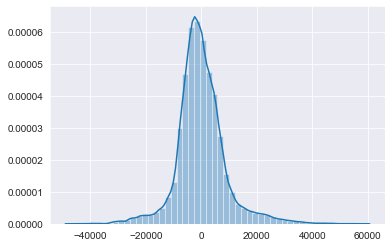

In [83]:
# plot residuals
sns.distplot(y_valid-y_pred)

In [84]:
# predict test data
y_pred = lm.predict(X_test)

In [85]:
print("Test MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("Test MSE" , metrics.mean_squared_error(y_test, y_pred))
print("Test RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Test R2" , metrics.explained_variance_score(y_test, y_pred))
print("Test Adjusted R2", 1-(1-(metrics.explained_variance_score(y_test, y_pred)))*(len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))

Test MAE 6197.893785561017
Test MSE 77623572.06588268
Test RMSE 8810.424057097518
Test R2 0.6721310153403699
Test Adjusted R2 0.6689224554457558


# Model 2: Random Forest

In [64]:
# create model instance
rf = RandomForestRegressor()

# fit model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [66]:
# predict validation data
y_pred = rf.predict(X_valid)

In [67]:
print("MAE" , metrics.mean_absolute_error(y_valid, y_pred))
print("MSE" , metrics.mean_squared_error(y_valid, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))
print("R2" , metrics.explained_variance_score(y_valid, y_pred))
print("Adjusted R2", 1-(1-(metrics.explained_variance_score(y_valid, y_pred)))*(len(X_valid)-1)/(len(X_valid)-X_valid.shape[1]-1))

MAE 1157.5311105160242
MSE 5379236.433354012
RMSE 2319.3180966296995
R2 0.9771499421626864
Adjusted R2 0.9770944491084559


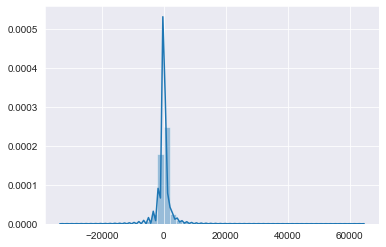

In [68]:
# plot residuals
sns.distplot(y_valid-y_pred)

With more time and more computational power, it would be worth coming back to improve the model by tuning the model hyperparameters. However, for now the performance is acceptable and we can move on to predict the test data.

In [69]:
# predict test data
y_pred = rf.predict(X_test)

In [70]:
print("Test MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("Test MSE" , metrics.mean_squared_error(y_test, y_pred))
print("Test RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Test R2" , metrics.explained_variance_score(y_test, y_pred))
print("Test Adjusted R2", 1-(1-(metrics.explained_variance_score(y_test, y_pred)))*(len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))

Test MAE 1139.9558774901363
Test MSE 4924107.052809853
Test RMSE 2219.032909357104
Test R2 0.9791982042800864
Test Adjusted R2 0.9789946357493449


# Model 3: Extreme Gradient Boosting 

In [71]:
# set up the classifier. Once again we will use the default parameters as starting point
xgbr = XGBRegressor()

# fit the model on the training set
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [73]:
# predict validation data
y_pred = xgbr.predict(X_valid)

In [74]:
print("MAE" , metrics.mean_absolute_error(y_valid, y_pred))
print("MSE" , metrics.mean_squared_error(y_valid, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))
print("R2" , metrics.explained_variance_score(y_valid, y_pred))
print("Adjusted R2", 1-(1-(metrics.explained_variance_score(y_valid, y_pred)))*(len(X_valid)-1)/(len(X_valid)-X_valid.shape[1]-1))

MAE 2677.2681312035193
MSE 17095712.46315524
RMSE 4134.696175434809
R2 0.9273791361799794
Adjusted R2 0.9272027710450235


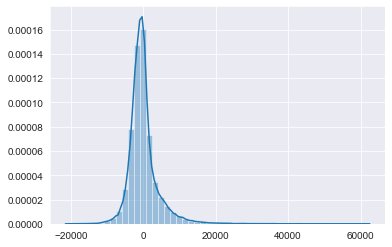

In [75]:
sns.distplot(y_valid-y_pred)

In [78]:
# predict test data
y_pred = xgbr.predict(X_test)

In [79]:
print("Test MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("Test MSE" , metrics.mean_squared_error(y_test, y_pred))
print("Test RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Test R2" , metrics.explained_variance_score(y_test, y_pred))
print("Test Adjusted R2", 1-(1-(metrics.explained_variance_score(y_test, y_pred)))*(len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))

Test MAE 2659.998773056535
Test MSE 16043833.548802372
Test RMSE 4005.475446036634
Test R2 0.9322273005450046
Test Adjusted R2 0.9315640698778929


# Model Comparison

Due to limited computational resources we will simply go with the default model results. Ideally, we would go back and tune the model hyperparameters to further improve the model performance by reducing the prediction error.

To compare the 3 models, we will use adjusted R2 and RMSE metrics.

**Why Adj R2?**

Adjusted Rsquared = 1 - (1 - R2) * ((n - 1) / (n - p - 1))

where p is the total number of explanatory variables in the model (not including the constant term), and n is the sample size. It can also be written as:

Why is adjusted Rsquared used? The adjusted R-squared compensates for the addition of variables and only increases if the new predictor enhances the model above what would be obtained by probability.

R-square test is used to determine the goodness of fit in regression analysis. Goodness of fit implies how better regression model is fitted to the data points. More is the value of r-square near to 1, better is the model. But the problem lies in the fact that the value of r-square always increases as new variables(attributes) are added to the model, no matter that the newly added attributes have a positive impact on the model or not. also, it can lead to over fitting of the model if there are large no. of variables.

Adjusted r-square is a modified form of r-square whose value increases if new predictors tend to improve model’s performance and decreases if new predictors does not improve performance as expected.

Source= https://www.geeksforgeeks.org/ml-adjusted-r-square-in-regression-analysis/

**Why RMSE?**

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.

We will use RMSE because this metric has some advantages over MAE and MSE. The MAE fails to punish large prediction errors and might therefore be misleading. MSE is a way to punish these outlier prediction errors by squaring each error and then taking the mean, however, it is difficult to compare this metric with the actual outcome value since its unit is squared. That's when RMSE comes into play. It entails simply taking the square root of the MSE metric which means it still punishes outlier but is now in the same units as the outcome value which makes it easy to evaluate.

The lower the RMSE value, the better the fit.

Source: https://www.google.com/search?q=rmse&rlz=1C1CHBF_enUS902US902&oq=RMSE&aqs=chrome.0.0l8.575j0j4&sourceid=chrome&ie=UTF-8

In [99]:
print("Linear Regression\nRMSE: {}\nadj R2: {}".format(8810.42, 0.6689))
print("\nRandom Forest\nRMSE: {}\nadj R2: {}".format(2219.03, 0.9789))
print("\nXGBoost\nRMSE: {}\nadj R2: {}\n".format(4005.47,0.9315))

Linear Regression
RMSE: 8810.42
adj R2: 0.6689

Random Forest
RMSE: 2219.03
adj R2: 0.9789

XGBoost
RMSE: 4005.47
adj R2: 0.9315



We can clearly see that Linear Regression did not perform well on our data. Presumably, because this model fails at finding relationships that are non-linear in nature. Our dataset probably has these types of relationships. On the other side, the Random Forest model performed very well. It showed an adj R2 of 0.9789 which means the model can explain around 97% of the variance in the data. Further, it displays an RMSE of 2219.03, which is the lowest error among the 3 models. Therefore, the Random Forest model is selected as best performing model.

# Next Steps - Ways to potentially improve the model(s)

- PCA to reduce dimensionality
- Re-assess feature selection
- Hyperparameter tuning
- Create a function to measure time while training RF (It takes quite long)
- Try AutoRegressive Integrated Moving Average model

# 5) Saving the Random Forest model

In [89]:
# Save to file to working directory
joblib_file = "joblib_final_model_Walmart.pkl"
joblib.dump(rf, joblib_file)

['joblib_final_model_Walmart.pkl']

In [90]:
# Load from file
final_model = joblib.load("joblib_final_model_Walmart.pkl")

In [93]:
# Calculate the accuracy and predictions
final_model.score(X_test, y_test) # regular R2 value 
#print("Test Accuracy: {0:.2f} %".format(100 * score))

0.9791963767878759

**We can now use the model to predict future weekly store sales**